## Requirements

This project requires the following Python libraries to run:

- NumPy
- SciPy
- Matplotlib
- IPython
- sounddevice

To install all of these simultaneously, run the following in your terminal:

```pip install numpy scipy matplotlib ipython sounddevice```

You also need Python and a Python Notebook viewer. (I would suggest using Jupyter.)

## Voice Activity Detectors

Voice activity detectors, or VADs, are devices that can determine if a given spectral frame contains speech. We use VADs to develop a noise profile for STSA techniques.

In [1]:
import numpy as np

class abstract_vad:
    def is_speech(self, data, inverse = False):
        pass

class vad:
    class psd_threshold(abstract_vad):
        threshold = 0.0

        def __init__(self, threshold):
            self.threshold = threshold

        def is_speech(self, data, inverse = False):
            X = data
            return (np.average(np.abs(X) ** 2) >= self.threshold if not inverse else
                    np.average(np.abs(X) ** 2) < self.threshold)

    class adaptive_avg_psd(abstract_vad):
        avg = 0
        k: np.uint64 = 0

        def is_speech(self, data, inverse = False):
            X = data

            self.avg += (1 / (self.k + 1)) * (np.average(np.abs(X) ** 2) - self.avg)
            self.k += 1

            return (np.average(np.abs(X) ** 2) >= self.avg if not inverse else
                    np.average(np.abs(X) ** 2) < self.avg) 

## Spectral Processing: Processors

Processors are abstract machines that process spectral data for spectral processing. In this implementation, we are mainly focused on STSA processors.

![runner-processor-setup](figures/fig5.png "Runner/Processor Setup")

In [57]:
import numpy as np

class abstract_spectral_processor():
    def process(self, X):
        pass

# Collection of STSA techniques, all of which are descendants of abstract_spectral_processor.
class stsa:
    # Spectral Subtraction
    class subtraction:
        class simplified_weiss(abstract_spectral_processor):
            a = 0
            k = 0
            vad: abstract_vad = None

            def __init__(self, a, k, vad: abstract_vad):
                self.a = a
                self.k = k
                self.vad = vad

            def process(self, X):
                noise_segments = [self.vad.is_speech(frame, inverse = True) for frame in X]
                D = X[noise_segments]
                E_D = np.average(np.abs(D) ** self.a, axis = 0)

                S_hat_mag = ((np.abs(X) ** self.a) - self.k * E_D)
                S_hat_mag[S_hat_mag < 0] = 0
                S_hat_mag **= (1 / self.a)

                S_hat_phase = np.angle(X)
                S_hat = S_hat_mag * np.exp(1j * S_hat_phase)
                S_hat[noise_segments] *= 0.001

                return S_hat

        class psd(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.subtraction.simplified_weiss(2, 1, self.vad).process(X)

        class boll(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.subtraction.simplified_weiss(1, 1, self.vad).process(X)

        class mle(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                noise_segments = [self.vad.is_speech(frame, inverse = True) for frame in X]
                D = X[noise_segments]
                E_D = np.average(np.abs(D) ** 2, axis = 0)

                S_hat_mag = (0.5 * np.abs(X)) + (0.5 * (np.abs(X) ** 2)) - np.sqrt(E_D)
                S_hat_phase = np.angle(X)
                S_hat = S_hat_mag * np.exp(1j * S_hat_phase)

                S_hat[noise_segments] *= 0.001

                return S_hat
        
    # Source-Filter
    class filters:
        class generalized_wiener(abstract_spectral_processor):
            alpha = 0
            beta = 0
            vad: abstract_vad = None

            def __init__(self, alpha, beta, vad: abstract_vad):
                self.alpha = alpha
                self.beta = beta
                self.vad = vad

            def process(self, X):
                noise_segments = [self.vad.is_speech(frame, inverse = True) for frame in X]
                D = X[noise_segments]
                E_D = np.average(np.abs(D) ** 2, axis = 0)

                SNR_priori = (np.abs(X) ** 2) / (E_D if E_D > 0 else 1)

                H = ((SNR_priori) / (1 + self.alpha * SNR_priori)) ** self.beta
                S_hat = H * X
                S_hat[noise_segments] *= 0.001

                return S_hat
            
        class wiener(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.filters.generalized_wiener(1, 1, self.vad).process(X)
        
        class psd(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.filters.generalized_wiener(1, 0.5, self.vad).process(X)

        class mle(abstract_spectral_processor):
            vad: abstract_vad = None

            def __init__(self, vad: abstract_vad):
                self.vad = vad

            def process(self, X):
                return stsa.filters.generalized_wiener(1, 2, self.vad).process(X)

## Spectral Processing: Runners

Runners are abstract code segments that "run" the spectral processor. They take temporal audio samples, convert it to spectral data, send it to the processor, convert it back to temporal data, and return it.

![offline](figures/fig6a.png "Offline Spectral Runner")
![realtime](figures/fig6b.png "Real-Time Spectral Runner")

In [ ]:
# Runners

import numpy as np
import scipy

class abstract_spectral_runner:
    processor: abstract_spectral_processor = None

    def __init__(self, processor):
        self.processor = processor

    def run(self, x):
        pass

class offline_runner(abstract_spectral_runner):
    N = 2048
    M = int(0.25 * N)
    W = np.hanning(N)
    sr = 48000
    sft = scipy.signal.ShortTimeFFT(W, M, fs = sr)

    def __init__(self, processor, N = N, M = M, W = W, sr = sr):
        self.processor = processor

        self.N = N
        self.M = M
        self.W = W
        self.sr = sr

        self.sft = scipy.signal.ShortTimeFFT(W, M, fs = sr)

    def run(self, x):
        X = self.sft.stft(x).T
        X_processed = np.asarray([self.processor.process(frame) for frame in X])
        return self.sft.istft(X_processed.T)
    
class realtime_runner(abstract_spectral_runner):
    N = 2048
    M = int(0.25 * N)
    W = np.hanning(N)

    input_buf = np.zeros(N)
    input_write_idx = 0
    output_buf = np.zeros(M + N)
    output_read_idx = 0
    output_write_idx = 0

    output_block_size = 64

    def __init__(self, processor, N = N, M = M, W = W, output_block_size = output_block_size):
        self.processor = processor
        self.N = N
        self.M = M
        self.W = W
        self.output_block_size = output_block_size

        self.input_buf = np.zeros(N)
        self.output_buf = np.zeros(M + N)

    # This implementation is very similar to my converb~ Pure Data object.
    # See here: https://github.com/foobiane/converb-/blob/master/src/converb~.c
    def run(self, x):
        # Read in x
        for i in range(len(x)):
            self.input_buf[self.input_write_idx + i] = x[i]

        self.input_write_idx += len(x)

        # Process when input buffer is full
        if (self.input_write_idx == len(self.input_buf)):
            # Spectral processing
            X = scipy.fft.fft(self.W * self.input_buf)
            X_processed = self.processor.process(X)
            x_processed = (scipy.fft.ifft(X_processed)).real

            # Writing to circular buffer; overlap-add for first M samples, overwrite for the remainder
            for i in range(len(x_processed)):
                if i < self.N - self.M:
                    self.output_buf[(self.output_write_idx + i) % len(self.output_buf)] += x_processed[i]
                else:
                    self.output_buf[(self.output_write_idx + i) % len(self.output_buf)] = x_processed[i]
            
            # Advance by hop size
            self.output_write_idx = (self.output_write_idx + self.M) % len(self.output_buf)

            # Samples that overlap with the next frame are kept in the input buffer for later
            for i in range(overlap := self.N - self.M):
                self.input_buf[i] = self.input_buf[self.M + i]

            self.input_write_idx = overlap

        # Read from output buffer
        output_block = np.zeros(self.output_block_size)
        for i in range(self.output_block_size):
            output_block[i] = self.output_buf[(self.output_read_idx + i) % len(self.output_buf)]

        self.output_read_idx = (self.output_read_idx + self.output_block_size) % len(self.output_buf)

        return output_block
        



## Examples

/var/folders/cd/jgfs8rys5r98h33wkdxnjfl00000gn/T/ipykernel_13393/460103133.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, x = scipy.io.wavfile.read("noisy_signal.wav")


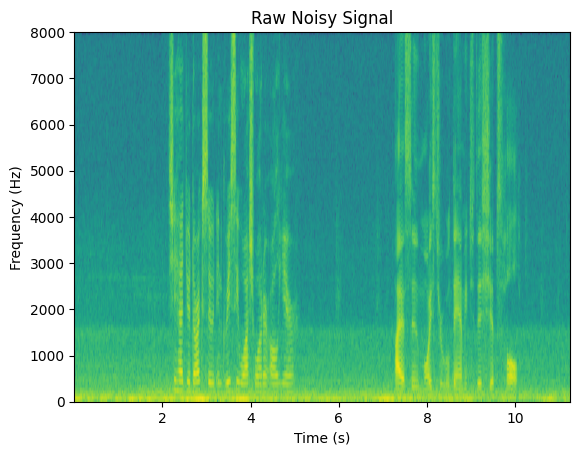

In [14]:
import IPython
import matplotlib.pyplot as plt
import scipy

sr, x = scipy.io.wavfile.read("noisy_signal.wav")

plt.specgram(x, Fs = sr)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Raw Noisy Signal")

plt.show()

IPython.display.Audio(x, rate = sr)

### Spectral Subtraction (Power Spectral Density)

Try experimenting with different thresholds!

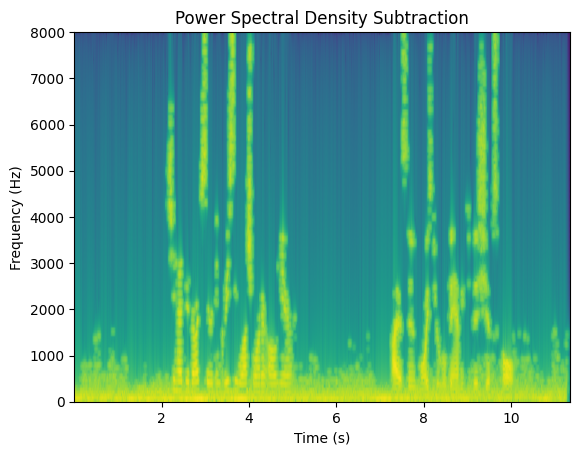

In [15]:
import matplotlib.pyplot as plt

threshold = 1e7
psds = offline_runner(processor = stsa.subtraction.psd(vad = vad.psd_threshold(threshold))).run(x)
plt.specgram(psds, Fs = sr)

plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Power Spectral Density Subtraction")

plt.show()

IPython.display.Audio(psds, rate = sr)

### Source-Filter (Wiener Filtering)

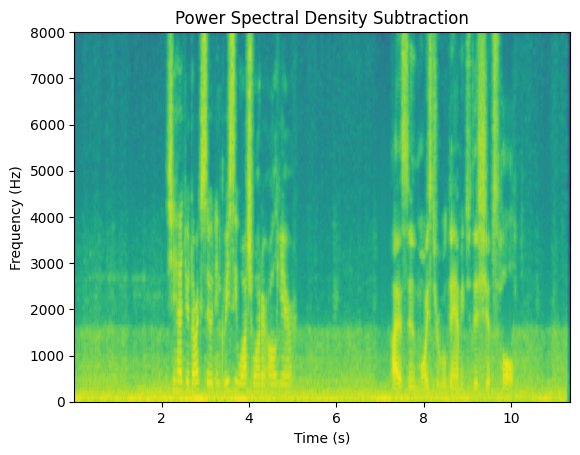

In [ ]:
import matplotlib.pyplot as plt

threshold = 1e7
psds = offline_runner(processor = stsa.filters.wiener(vad = vad.psd_threshold(threshold))).run(x)
plt.specgram(psds, Fs = sr)

plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Wiener Filtering")

plt.show()

IPython.display.Audio(psds, rate = sr)

## Real-Time

Some implicit assumptions...

- $n_b < N$ and $N \mod n_b = 0$
- $n_b$ is sufficiently small ()

In [65]:
import numpy as np
import sounddevice as sd

sr = 48000 # change this to your sound device's sample rate

n_b = 64
s = sd.Stream(dtype = "float32", blocksize = n_b, samplerate = sr, channels = 1)

realtime = realtime_runner(stsa.filters.wiener(vad.adaptive_avg_psd()), N = 8192, M = 4096, W = np.hanning(8192), output_block_size = n_b)

s.start()
while (True):
    in_data = s.read(n_b)[0]
    out_data = np.float32(realtime.run(in_data))
    s.write(out_data)

# Once you start running this block, you can only stop it by clicking the square icon.

/var/folders/cd/jgfs8rys5r98h33wkdxnjfl00000gn/T/ipykernel_13393/96532355.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.input_buf[self.input_write_idx + i] = x[i]


KeyboardInterrupt: 